# Milestone 2

## Imports

# Quotebank preprocessing

Most of the code used for the quotebank preprocessing can be found in the classes QuotebankData and Keyword, in addition to in files for helper functions. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import random
import os
import bz2
from src.QuoteBankData import QuoteBankData
from src.Deaths import Deaths
import src.utilities.quotebank_preprocessing_utils as utils
from src.CONSTS import DATA_PATH, COLORS, KEYWORDS_JSON_FILE_PATH, KEYWORDS_FILE_PATH, BEGIN_YEAR, END_YEAR
from tqdm import tqdm
from src.utilities.synonym_utils import add_new_synonyms
from src.utilities.add_features import expand_line
from src.utilities.utils import *

[nltk_data] Downloading package wordnet to C:\Users\Henrik Øberg
[nltk_data]     Myhre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Initialize quotebank
- read keyword and synonyms for death causes
- create folders and file names for quotes that matches keywords or synonyms
- match keywords and synonyms with quotes

load database of speakers


In [ ]:
quotebank = QuoteBankData("Asymmetry of News", [])
quotebank.read_keywords_from_file()
utils.create_directories_for_every_year()
quotebank.create_json_dumps_filenames_for_each_keyword()

In [ ]:
#quotebank.print_pretty_keywords_filenames()

In [ ]:
import warnings
import collections

warnings.filterwarnings("ignore")

def save_meta_data_quotes():
    quotebank.quotes_occurrences_df = pd.DataFrame()
    for year in range(BEGIN_YEAR, END_YEAR + 1):
        dict_df_row = {"Year": year}
        for key in quotebank.keywords:
            file = key.output_filenames[year-BEGIN_YEAR]
            with open(file, 'rU') as f:
                quotes = pd.read_json(file, lines=True)
            if len(quotes) > 0:
                # Save total number of quotes per year per topic in df
                num_of_quotes = quotes["n_appearances"].sum()
                

                for _, line_quotes in quotes.iterrows():
                    # Safe number of quotes per topic per year per country of url
                    country_urls = line_quotes['country_urls']
                    for country in country_urls:
                        if country in key.country_url_occurences:
                            key.country_url_occurences[country] += 1
                        else:
                            key.country_url_occurences[country] = 1

                    # Safe number of quotes per topic per year per country of speaker
                    country_speaker = line_quotes['country_speaker']
                    if country_speaker:
                        if isinstance(country_speaker, list):        # if multiple countries, take most occuring
                            print(country_speaker)
                            country_speaker = collections.Counter(country_speaker).most_common(1)[0][0]

                        if country_speaker in key.country_speaker_occurences:
                            key.country_speaker_occurences[country_speaker] +=1
                        else:
                            key.country_speaker_occurences[country_speaker] = 1 
            else:
                num_of_quotes = 0
            dict_df_row[key.name] = num_of_quotes
            
        quotebank.quotes_occurrences_df = quotebank.quotes_occurrences_df.append(dict_df_row, ignore_index = True)
        cols = quotebank.quotes_occurrences_df.columns
        quotebank.quotes_occurrences_df[cols] = quotebank.quotes_occurrences_df[cols].astype(int)

In [ ]:
save_meta_data_quotes()

In [ ]:
quotebank.quotes_occurrences_df

To illustrate the results, we plot the number of quotes found for each issue in 2016

In [ ]:
quotebank.quotes_percentage_df = percentage_of_total_count(quotebank.quotes_occurrences_df, quotebank.get_all_keyword_names())

In [ ]:
quotebank.quotes_percentage_df

In [ ]:
occurences = list()
x_labels = list()
x_number = list()
count = 0
for key in quotebank.keywords:
    with open(key.output_filenames[8], 'rU') as f:
        key.quotes = pd.read_json(key.output_filenames[8], lines=True)
    occurences.append(len(key.quotes))
    x_labels.append(key.name)
    x_number.append(count)
    count += 1

In [ ]:
plt.bar(x_number, occurences, log = True)
plt.xticks(x_number, x_labels)
plt.xticks(rotation=90)
plt.title("Number of occurences per topic in 2016")
plt.xlabel("Topics")
plt.ylabel("Number of occurences")
plt.show()

In [ ]:
def freq_per_month(df):
    freqs = np.zeros(12)
    for i in range(12):
        freqs[i] = np.sum(df["date"].dt.month == i+1)
    return freqs

In [ ]:
all_freq = list()
for keys in quotebank.keywords:
    if not keys.quotes.empty:
        all_freq.append(freq_per_month(keys.quotes))
    else:
        all_freq.append(np.zeros(12))
df = pd.DataFrame(all_freq)

plt.plot(np.sum(df))
plt.title("Number of topic quotes found throughout the year 2016")
plt.show()

# Population data preprocessing
This is population data from the UN, which we might use in combination with the Our World in Data datasets to get a more realistic understanding of the relative deaths each year.

In [ ]:
population_path = DATA_PATH + "annual_population_data.csv"
raw_population_df = pd.read_csv(population_path)
raw_population_df

Extracting world population in millions from 2008 to 2017

In [ ]:
population_df = raw_population_df[(raw_population_df["Location"] == "World") & (raw_population_df["Time"] > 2007) & (raw_population_df["Time"] < 2018)]
population_df = population_df[["Time", "PopTotal"]].reset_index(drop=True)
population_df["PopTotal"] = population_df["PopTotal"].apply(lambda x: x/1000)
population_df = population_df.rename(columns = {"Time": "Year", "PopTotal": "World population millions"})
population_df

# Our World in Data preprocessing

This part of the notebook is more exploratory. We wanted to preprocess and look at the two main datasets form Our World in Data to be sure that the project is possible to do. 

## Preprocess death data

### Deaths by cause

{'Terrorism (deaths)': 'Terrorism', 'Deaths - Self-harm - Sex: Both - Age: All Ages (Number)': 'Suicide', 'Deaths - Meningitis - Sex: Both - Age: All Ages (Number)': 'Meningitis', 'Deaths - Lower respiratory infections - Sex: Both - Age: All Ages (Number)': 'Lower_respiratory_infections', 'Deaths - Intestinal infectious diseases - Sex: Both - Age: All Ages (Number)': 'Intestinal_infectious_diseases', 'Deaths - Protein-energy malnutrition - Sex: Both - Age: All Ages (Number)': 'Protein-energy_malnutrition', 'Deaths - Cardiovascular diseases - Sex: Both - Age: All Ages (Number)': 'Cardiovascular_diseases', 'Deaths - Alzheimer disease and other dementias - Sex: Both - Age: All Ages (Number)': 'Alzheimer_disease_and_other_dementias', 'Deaths - Chronic kidney disease - Sex: Both - Age: All Ages (Number)': 'Chronic_kidney_disease', 'Deaths - Chronic respiratory diseases - Sex: Both - Age: All Ages (Number)': 'Chronic_respiratory_diseases', 'Deaths - Cirrhosis and other chronic liver diseases

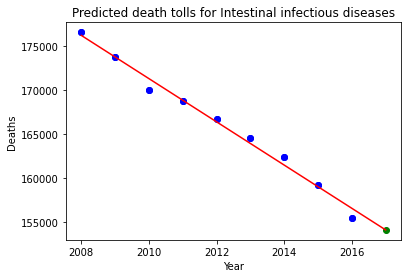

,Entity,Code,Year,Meningitis,Lower respiratory infections,Intestinal infectious diseases,Cardiovascular diseases,Alzheimer disease and other dementias,Chronic kidney disease,Chronic respiratory diseases,...,Maternal disorders,Neonatal disorders,Diarrheal diseases,Suicide,Diabetes mellitus,Poisonings,War and terrorism,Exposure to forces of nature,Nutritional deficiencies,Drug use and alcoholism
0,World,OWID_WRL,2008,348040.083847,2.657275e+06,176583.045171,1.500828e+07,1.790400e+06,9.528553e+05,3.419369e+06,...,249888.643281,2.304429e+06,1.867836e+06,789447.007136,1.045381e+06,78008.099106,67952.082371,295881.442960,650025.252823,287619.724142
1,World,OWID_WRL,2009,340514.177436,2.639562e+06,173745.686452,1.527431e+07,1.863444e+06,9.866682e+05,3.469693e+06,...,246340.811729,2.258315e+06,1.865671e+06,791222.757559,1.070186e+06,77339.491051,77189.308722,68277.808308,635954.543146,285320.956384
2,World,OWID_WRL,2010,331205.914662,2.623649e+06,170071.404053,1.561962e+07,1.943961e+06,1.019565e+06,3.522114e+06,...,242374.367555,2.211208e+06,1.857640e+06,796083.645174,1.096402e+06,77298.902918,58435.273695,363837.299083,641791.080428,288506.378358
3,World,OWID_WRL,2011,325000.383494,2.616651e+06,168716.792532,1.585974e+07,2.025064e+06,1.052780e+06,3.550905e+06,...,234088.413573,2.162070e+06,1.793641e+06,793977.906088,1.129959e+06,76227.682073,108814.611560,89366.680283,618725.210271,288507.494650
4,World,OWID_WRL,2012,316965.020009,2.605154e+06,166735.397312,1.611549e+07,2.098871e+06,1.082857e+06,3.555093e+06,...,221423.708544,2.110626e+06,1.725018e+06,786335.554940,1.168569e+06,75414.520357,126929.890101,64283.962330,579225.038064,292033.120011
5,World,OWID_WRL,2013,312013.523643,2.590482e+06,164572.376351,1.628402e+07,2.168918e+06,1.112929e+06,3.570845e+06,...,212655.973665,2.050610e+06,1.664193e+06,779212.549795,1.202743e+06,74906.641101,137411.255671,74874.464645,557568.566594,300325.129358
6,World,OWID_WRL,2014,306484.322622,2.579538e+06,162420.462719,1.662836e+07,2.253866e+06,1.147229e+06,3.638294e+06,...,206311.290374,1.989193e+06,1.619718e+06,781716.697241,1.249135e+06,74439.682294,226729.944451,61575.894639,539496.675896,311573.610921
7,World,OWID_WRL,2015,298711.517721,2.582199e+06,159257.591692,1.713999e+07,2.353634e+06,1.185372e+06,3.739118e+06,...,199530.977239,1.925458e+06,1.578439e+06,782941.162890,1.299556e+06,74394.517062,176482.287532,72488.354651,526248.610811,325986.603083
8,World,OWID_WRL,2016,295878.990018,2.574625e+06,155448.606112,1.752437e+07,2.440042e+06,1.216963e+06,3.826620e+06,...,196170.819390,1.852924e+06,1.550848e+06,788674.564776,1.346428e+06,73643.079320,193227.402289,61444.305454,511310.637890,341369.595111
9,World,OWID_WRL,2017,288021.105387,2.558606e+06,154107.234208,1.779095e+07,2.514619e+06,1.230168e+06,3.914196e+06,...,193639.310502,1.783770e+06,1.569556e+06,793823.469135,1.369849e+06,72370.531920,156165.145674,62952.453837,501767.909733,351546.790209


In [2]:
death_by_cause_path = DATA_PATH + "annual_number_of_deaths_by_cause.csv"
deaths_by_cause = Deaths("deaths_by_cause", death_by_cause_path, rename_cols = {'Terrorism (deaths)': 'Terrorism', 'Deaths - Self-harm - Sex: Both - Age: All Ages (Number)': 'Suicide'}, drop_cols = ['Number of executions (Amnesty International)'])
deaths_by_cause.df

In [3]:
deaths_by_cause.df.columns

Index(['Entity', 'Code', 'Year', 'Meningitis', 'Lower respiratory infections',
       'Intestinal infectious diseases', 'Cardiovascular diseases',
       'Alzheimer disease and other dementias', 'Chronic kidney disease',
       'Chronic respiratory diseases',
       'Cirrhosis and other chronic liver diseases', 'Digestive diseases',
       'Hepatitis', 'Neoplasms', 'Parkinson disease',
       'Fire, heat, and hot substances', 'Malaria', 'Drowning',
       'Interpersonal violence', 'Hiv/aids', 'Tuberculosis', 'Road injuries',
       'Maternal disorders', 'Neonatal disorders', 'Diarrheal diseases',
       'Suicide', 'Diabetes mellitus', 'Poisonings', 'War and terrorism',
       'Exposure to forces of nature', 'Nutritional deficiencies',
       'Drug use and alcoholism'],
      dtype='object')

In [4]:
deaths_by_cause.percentage_df

,Entity,Code,Year,Meningitis,Lower respiratory infections,Intestinal infectious diseases,Cardiovascular diseases,Alzheimer disease and other dementias,Chronic kidney disease,Chronic respiratory diseases,...,Maternal disorders,Neonatal disorders,Diarrheal diseases,Suicide,Diabetes mellitus,Poisonings,War and terrorism,Exposure to forces of nature,Nutritional deficiencies,Drug use and alcoholism
0,World,OWID_WRL,2008,0.700192,5.345947,0.355253,30.193900,3.601955,1.916969,6.879140,...,0.502730,4.636086,3.757741,1.588222,2.103115,0.156938,0.136707,0.595259,1.307731,0.578638
1,World,OWID_WRL,2009,0.682428,5.289976,0.348206,30.611429,3.734549,1.977393,6.953651,...,0.493694,4.525914,3.739013,1.585699,2.144772,0.154997,0.154696,0.136836,1.274524,0.571815
2,World,OWID_WRL,2010,0.653592,5.177430,0.335614,30.823280,3.836153,2.011978,6.950433,...,0.478294,4.363531,3.665810,1.570967,2.163606,0.152539,0.115314,0.717985,1.266491,0.569330
3,World,OWID_WRL,2011,0.640791,5.159152,0.332653,31.270041,3.992743,2.075727,7.001185,...,0.461543,4.262872,3.536454,1.565456,2.227897,0.150295,0.214546,0.176201,1.219917,0.568839
4,World,OWID_WRL,2012,0.622269,5.114465,0.327337,31.638096,4.120525,2.125876,6.979395,...,0.434701,4.143603,3.386573,1.543742,2.294146,0.148055,0.249190,0.126203,1.137141,0.573322
5,World,OWID_WRL,2013,0.610462,5.068342,0.321990,31.860088,4.243542,2.177473,6.986446,...,0.416067,4.012069,3.256034,1.524548,2.353196,0.146557,0.268848,0.146494,1.090897,0.587593
6,World,OWID_WRL,2014,0.591830,4.981157,0.313638,32.109811,4.352276,2.215331,7.025643,...,0.398393,3.841186,3.127720,1.509516,2.412113,0.143745,0.437822,0.118905,1.041783,0.601657
7,World,OWID_WRL,2015,0.567101,4.902279,0.302349,32.540099,4.468350,2.250416,7.098677,...,0.378808,3.655462,2.996650,1.486406,2.467194,0.141237,0.335050,0.137618,0.999078,0.618882
8,World,OWID_WRL,2016,0.554221,4.822619,0.291176,32.825503,4.570527,2.279535,7.167775,...,0.367454,3.470776,2.904948,1.477294,2.522040,0.137943,0.361941,0.115093,0.957754,0.639431
9,World,OWID_WRL,2017,0.534836,4.751165,0.286167,33.036636,4.669484,2.284342,7.268408,...,0.359576,3.312345,2.914563,1.474079,2.543720,0.134387,0.289989,0.116899,0.931750,0.652800


### Deaths by category

In [5]:
from src.Deaths import Deaths
from src.CONSTS import DATA_PATH

death_by_category_path = DATA_PATH + "categorized_annual_number_of_deaths.csv"
deaths_by_category = Deaths("deaths_by_category", death_by_category_path, rename_cols = {"Deaths - Communicable, maternal, neonatal, and nutritional diseases - Sex: Both - Age: All Ages (Number)": "Communicable diseases"})
deaths_by_category.df

{'Deaths - Communicable, maternal, neonatal, and nutritional diseases - Sex: Both - Age: All Ages (Number)': 'Communicable diseases', 'Deaths - Non-communicable diseases - Sex: Both - Age: All Ages (Number)': 'Non-communicable_diseases', 'Deaths - Injuries - Sex: Both - Age: All Ages (Number)': 'Injuries'}


,Entity,Code,Year,Non-communicable diseases,Communicable diseases,Injuries
0,World,OWID_WRL,2008,3.418150e+07,1.308734e+07,4.634715e+06
1,World,OWID_WRL,2009,3.483548e+07,1.281121e+07,4.425399e+06
2,World,OWID_WRL,2010,3.559222e+07,1.252802e+07,4.718076e+06
3,World,OWID_WRL,2011,3.621622e+07,1.219007e+07,4.487698e+06
4,World,OWID_WRL,2012,3.683037e+07,1.180971e+07,4.462361e+06
5,World,OWID_WRL,2013,3.735997e+07,1.146154e+07,4.452354e+06
6,World,OWID_WRL,2014,3.825766e+07,1.117078e+07,4.507679e+06
7,World,OWID_WRL,2015,3.945300e+07,1.088245e+07,4.486745e+06
8,World,OWID_WRL,2016,4.040355e+07,1.060071e+07,4.505297e+06
9,World,OWID_WRL,2017,4.107113e+07,1.038987e+07,4.484722e+06


In [6]:
deaths_by_category.quant_columns

['Non-communicable diseases', 'Communicable diseases', 'Injuries']

In [7]:
deaths_by_category.percentage_df

,Entity,Code,Year,Non-communicable diseases,Communicable diseases,Injuries
0,World,OWID_WRL,2008,65.855794,25.214733,8.929473
1,World,OWID_WRL,2009,66.898568,24.602832,8.498600
2,World,OWID_WRL,2010,67.360623,23.710107,8.929270
3,World,OWID_WRL,2011,68.469444,23.046231,8.484325
4,World,OWID_WRL,2012,69.357208,22.239485,8.403306
5,World,OWID_WRL,2013,70.128132,21.514385,8.357483
6,World,OWID_WRL,2014,70.931427,20.711133,8.357440
7,World,OWID_WRL,2015,71.965378,19.850444,8.184177
8,World,OWID_WRL,2016,72.786653,19.097091,8.116256
9,World,OWID_WRL,2017,73.412455,18.571344,8.016201


## Plotting

### Deaths by cause

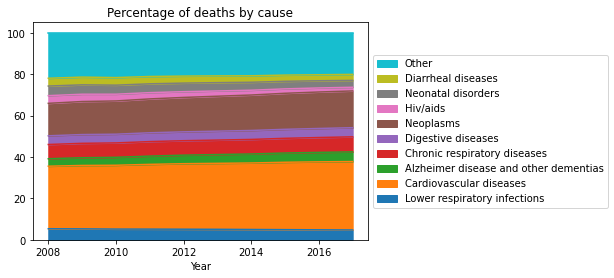

In [8]:
deaths_by_cause.plot_stacked_areas("", "Percentage of deaths by cause")

### Deaths by category

In [ ]:
deaths_by_category.plot_stacked_areas("Percentage deaths", "Percentage of deaths by category")

# RQ1

In [ ]:
def plot_RQ1():
    

In [ ]:
quotebank.quotes_percentage_df.columns

In [ ]:
plot_RQ1()

# RQ5

In [ ]:
def group_quotebank_cols():
    print(":)")

In [ ]:
def plot_RQ5():
    bar_labels = ["quotes", "deaths"]
    width = 0.35 
    for year in range(BEGIN_YEAR, END_YEAR + 1):
        prev_values = [0, 0]
        print("Year:",  year)
        fig, ax = plt.subplots()

        for column in deaths_by_cause.quant_columns:
            values = [quotebank.quotes_percentage_df.loc[quotebank.quotes_percentage_df["Year"] == year, column].item(), 
                      deaths_by_cause.percentage_df.loc[deaths_by_cause.percentage_df["Year"] == year, column].item()]

            ax.bar(bar_labels, values, width, bottom = prev_values, label=column)
            prev_values[0] += values[0]
            prev_values[1] += values[1]

        ax.set_ylabel('Percentage')
        ax.set_title('Percentages of quotes and deaths')
        ax.legend()

        plt.show()

In [ ]:
deaths_by_cause.quant_columns

In [ ]:
plot_RQ5()